As the number of groups increases, which algorithm performs better at scaling?

In [ ]:
import pandas as pd

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# Step 1: Load the data
df = pd.read_parquet(
    "results/psc-baselines-2.parquet", 
    columns=["algorithm", "n_groups", "np", "value"],
    filters=[("dist", "==", "uniform"), ("n_rows", "==", 8_000_000), ("attribute", "==", "aggregation_time")],
)

# Step 2: Preprocess
df["value"] = df["value"].apply(lambda x: float(x.removesuffix("ms")))
df = df.groupby(["algorithm", "n_groups", "np"])["value"].mean().reset_index()
df = df.rename(columns={"value": "latency"})

# Step 3: Add Speedup Column
baseline = df[df["np"] == 1][["algorithm", "n_groups", "latency"]]
baseline = baseline.rename(columns={"latency": "baseline_latency"})
df = df.merge(baseline, on=["algorithm", "n_groups"], how="left")
df["speedup"] = df["baseline_latency"] / df["latency"]
df = df.drop(columns=["baseline_latency"])

# Step 4: Add Tolerance Column
# Find the latency at the minimal n_groups for each (dist, algorithm, np)
min_group_latency = (
    df.loc[df.groupby(["algorithm", "np"])["n_groups"].idxmin()]
    [["algorithm", "np", "latency"]]
    .rename(columns={"latency": "min_group_latency"})
)

df = df.merge(min_group_latency, on=["algorithm", "np"], how="left")
df["slowdown"] = df["latency"] / df["min_group_latency"]
df = df.drop(columns=["min_group_latency"])

# Step 5: Display
for algorithm in df["algorithm"].unique():
    display(df[(df["np"] == df["np"].max()) & (df["algorithm"] == algorithm)])


What's the latency and speedup for these baseline algorithms?

In [68]:
import pandas as pd

# Step 1: Load the data
df = pd.read_parquet(
    "results/psc-baselines-2.parquet", 
    columns=["algorithm", "n_groups", "np", "trial_id", "value"],
    filters=[
        ("dist", "==", "uniform"), 
        ("n_rows", "==", 8_000_000), 
        ("attribute", "==", "aggregation_time"),
        ("algorithm", "in", [
            "two-phase-central-merge-xxhash",
            "two-phase-tree-merge",
            "two-phase-radix-xxhash",
            "omp-lock-free-hash-table",
        ])
    ],
)

# Step 2: Preprocess
df["value"] = df["value"].apply(lambda x: float(x.removesuffix("ms")))
df = df.rename(columns={"value": "latency"})
df = df.groupby(["algorithm", "n_groups", "np"], as_index=False)["latency"].mean()

# Step 3: Add Speedup Column
baseline = df[df["np"] == 1][["algorithm", "n_groups", "latency"]]
baseline = baseline.rename(columns={"latency": "baseline_latency"})
df = df.merge(baseline, on=["algorithm", "n_groups"], how="left")
df["speedup"] = df["baseline_latency"] / df["latency"]
df = df.drop(columns=["baseline_latency"])

display(df.sample(5))


,algorithm,n_groups,np,latency,speedup
24,omp-lock-free-hash-table,2000000,1,343.2,1.000000
12,omp-lock-free-hash-table,20000,16,63.6,2.487421
28,omp-lock-free-hash-table,2000000,16,82.0,4.185366
3,omp-lock-free-hash-table,2000,8,95.2,1.649160
27,omp-lock-free-hash-table,2000000,8,114.4,3.000000


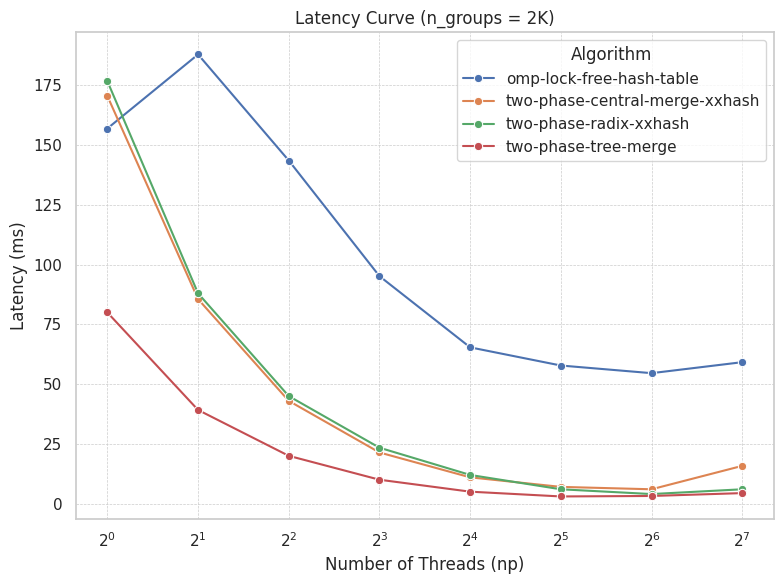

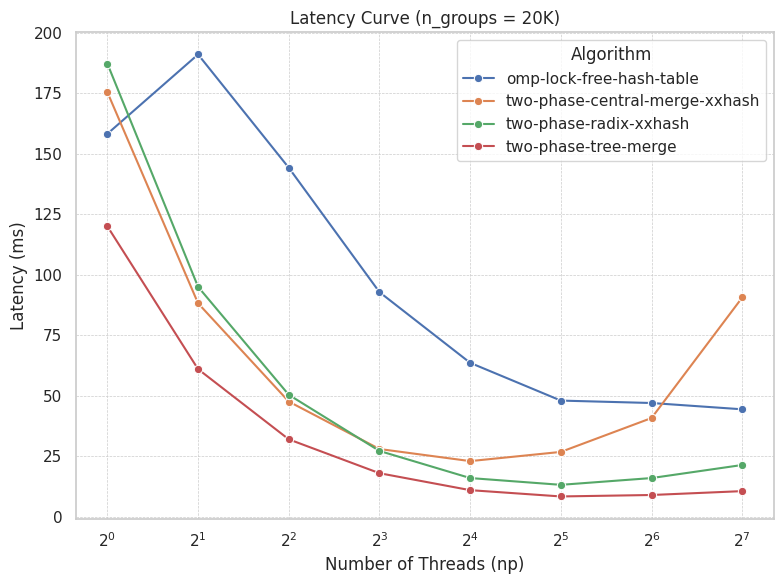

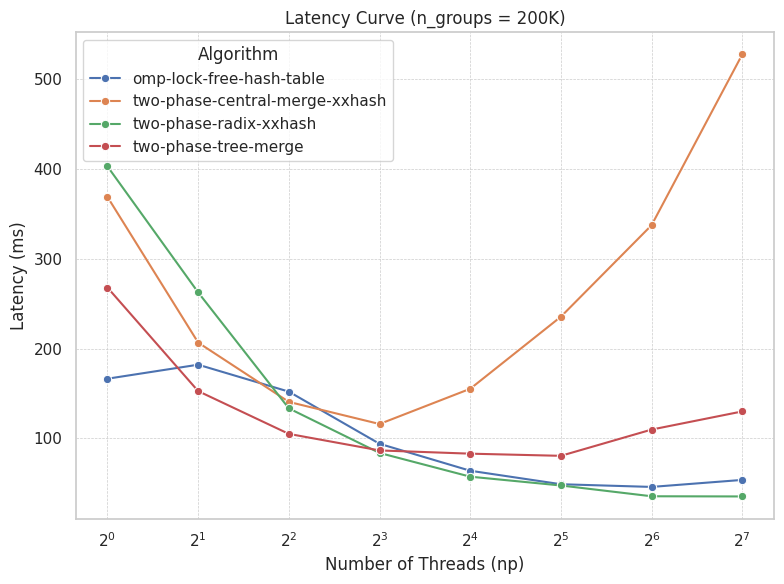

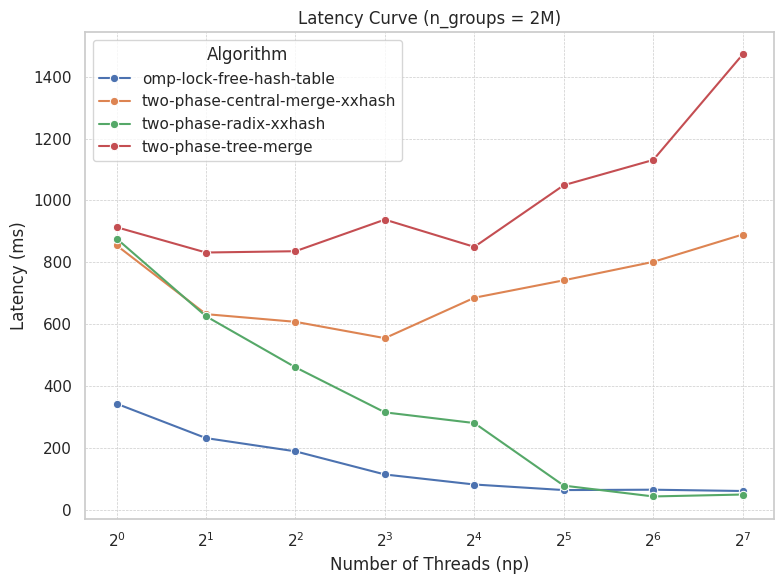

In [69]:
import matplotlib.pyplot as plt
import seaborn as sns

def format_number(n):
    if n >= 1_000_000_000: return f"{n//1_000_000}B"
    if n >= 1_000_000: return f"{n//1_000_000}M"
    if n >= 1_000: return f"{n//1_000}K"
    return str(n)

sns.set_theme(style="whitegrid")
for groups in sorted(df["n_groups"].unique()):
    subset = df[df["n_groups"] == groups]
    plt.figure(figsize=(8, 6))
    sns.lineplot(data=subset, x="np", y="latency", hue="algorithm", marker="o")
    plt.title(f"Latency Curve (n_groups = {format_number(groups)})")
    plt.xlabel("Number of Threads (np)")
    plt.ylabel("Latency (ms)")
    plt.xscale("log", base=2)
    plt.grid(True, which="both", linestyle="--", linewidth=0.5)
    plt.legend(title="Algorithm", frameon=True)
    plt.tight_layout()
    plt.savefig(f"results/latency_curve_ngroups_{format_number(groups)}.png", dpi=300)
    plt.show()
